In [55]:
import pandas as pd
import matplotlib.pyplot as plt # for plotting data

from bs4 import BeautifulSoup
import requests # fetches html content of a website
from urllib.request import HTTPError # for catching timeout for website response
from urllib.request import urlopen
from urllib.request import URLError

import time # for sleep function
from datetime import datetime, timedelta # for timestamp

import re # for regular expressions
import os
import numpy as np

In [130]:
# B12 js query for capacity
URL = 'https://111.webclimber.de/de/trafficlight?\
callback=WebclimberTrafficlight.insertTrafficlight&\
key=184xNhv6RRU7H2gVg8QFyHCYxym8DKve&\
hid=111&\
container=trafficlightContainer&\
type=&\
area='

In [2]:
def webpage2soup(url, parser="html.parser"):
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)\
     AppleWebKit/537.36 (KHTML, like Gecko)\
     Chrome/41.0.2228.0 Safari/537.36',
    }
    res = requests.get(url, headers=headers)
    res.raise_for_status()

    soup = BeautifulSoup(res.text, parser)
    return soup
            
def online(url="http://google.com"):
    Online = False
    try:
        urlopen(url, timeout=1)
        Online = True
    except URLError as err:
        Online = False
    return Online

def get_current_capacity():
    js_query = 'https://111.webclimber.de/de/trafficlight?\
    callback=WebclimberTrafficlight.insertTrafficlight&\
    key=184xNhv6RRU7H2gVg8QFyHCYxym8DKve&\
    hid=111&\
    container=trafficlightContainer&\
    type=&\
    area='
    
    soup = webpage2soup(js_query)
    percentage_str, num_str = [str(x) for x in soup.div.find_all("div")[-2:]]
    
    
    percentage_template = r"[0-9]+%"
    regex = re.compile(percentage_template)
    m = regex.search(percentage_str)
    percentage = int(m.group()[:-1])

    num_template = r"[0-9]+"
    regex = re.compile(num_template)
    m = regex.search(num_str)
    num = int(m.group())
    return num, percentage

def str2datetime(string, fmt="%H:%M"):
    if type(string) is str:
        return datetime.strptime(string, fmt)
    if type(string) is list:
        return [datetime.strptime(x, fmt) for x in string]

def is_open(timestamp=datetime.now()):
    state = False
    opening_times = {"Mon":["09:30","23:00"], 
                     "Tue":["09:30","23:00"], 
                     "Wed":["08:30","23:00"], 
                     "Thu":["12:30","23:00"], 
                     "Fri":["09:30","23:00"], 
                     "Sat":["10:00","22:00"], 
                     "Sun":["10:00","21:30"]}
    weekdays = list(opening_times.keys())
    
    day = weekdays[timestamp.weekday()]
    opening_time, closing_time = str2datetime(opening_times[day])
    
    if timestamp.time() > opening_time.time() and timestamp.time() < closing_time.time():
        state = True

    return state

In [5]:
log = pd.DataFrame(columns=["Free Spots", "Capacity", "Time", "Weekday", "DateTime"])
save2file = "log.csv"

if os.path.isfile(save2file):
    print("logfile already exists, adding new data to existing file.")
    log = pd.read_csv(save2file, sep=";")

while True:
    now = datetime.now() # neccesary?
    if is_open(now):
        if online():
            timestamp = datetime.now()
            timestamp_str = datetime.strftime(timestamp, "%H:%M, %m/%d/%Y")
            weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
            timeofday = datetime.strftime(timestamp, "%H:%M")
            day = weekdays[timestamp.weekday()]

            print("fetching data from B12 API @ " + timestamp_str, end=" --> ")
            payload = get_current_capacity()
            absolute, relative = payload
            update = pd.DataFrame({"Free Spots":[absolute], 
                                   "Capacity":[relative], 
                                   "Time":[timeofday], 
                                   "Weekday":[day], 
                                   "DateTime":[timestamp_str]
                                  })
            print("Free Spots = {0}, Capacity = {1}%.".format(absolute, relative))
            #print("updating logfile")
            log = log.append(update, ignore_index=True, sort=False)
            log.to_csv(save2file, index=False, sep=";")
            time.sleep(60*5)
        else:
            print("Error while trying to reach internet. Waiting 5min then trying again...")
            time.sleep(60*5)
    else:
        time.sleep(60*5)

The B12 is currently closed. Waiting till it opens again @ 10:00.


KeyboardInterrupt: 

In [3]:
is_open(str2datetime("23:33, 08/28/2020", "%H:%M, %m/%d/%Y"))

False

### Import

In [15]:
data = pd.read_csv("log.csv", sep=";")
str2date = lambda x: datetime.strptime(x, "%H:%M, %m/%d/%Y")
data["DateTime"] = data["DateTime"].apply(str2date)
data["Time"] = data["DateTime"].apply(datetime.time)
data["Date"] = data["DateTime"].apply(datetime.date)
data.head()

,Free Spots,Capacity,Time,Day,DateTime,Weekday,Date
0,17,76,18:51:00,NaN,2020-08-28 18:51:00,Fri,2020-08-28
1,17,76,18:56:00,NaN,2020-08-28 18:56:00,Fri,2020-08-28
2,14,80,19:01:00,NaN,2020-08-28 19:01:00,Fri,2020-08-28
3,14,80,19:06:00,NaN,2020-08-28 19:06:00,Fri,2020-08-28
4,13,82,19:11:00,NaN,2020-08-28 19:11:00,Fri,2020-08-28


In [28]:
def plot_summary_stats(data, metrics=["Free Spots", "Capacity"], plotsize=(15,20)):
    n_stats = 4
    fig, ax = plt.subplots(n_stats,len(metrics), figsize=plotsize)
    ax = ax.reshape(n_stats,len(metrics))
    
    x_step = round(data["DateTime"].shape[0]/n_stats)
    weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    for idx, metric in enumerate(metrics):
        ax[0,idx].plot(data["DateTime"], data[metric], marker=".")
        ax[0,idx].set_xticks(data["DateTime"][::x_step])
        ax[0,idx].set_xlabel("time")
        ax[0,idx].set_ylabel(metric)

        for day in weekdays:
            by_day = data[data["Day"] == day]
            by_day = by_day.rename(columns={metric:day})
            by_day.set_index('Time')[day].plot(ax=ax[1,idx], legend=True)
        ax[1,idx].set_xlabel("time")
        ax[1,idx].set_ylabel(metric)

        #data.groupby("Day").mean()[metric].plot(kind="bar", ax=ax[2,idx])
        data.set_index("Time").groupby("Day")[metric].plot(kind="box", ax=ax[2,idx])
        # density plot / rasterplot / heatmap day, time, capacity/free spots
    plt.show()

/home/jnsbck/Applications/anaconda3/envs/default/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/jnsbck/Applications/anaconda3/envs/default/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/jnsbck/Applications/anaconda3/envs/default/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/jnsbck/Applications/anaconda3/envs/default/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compariso

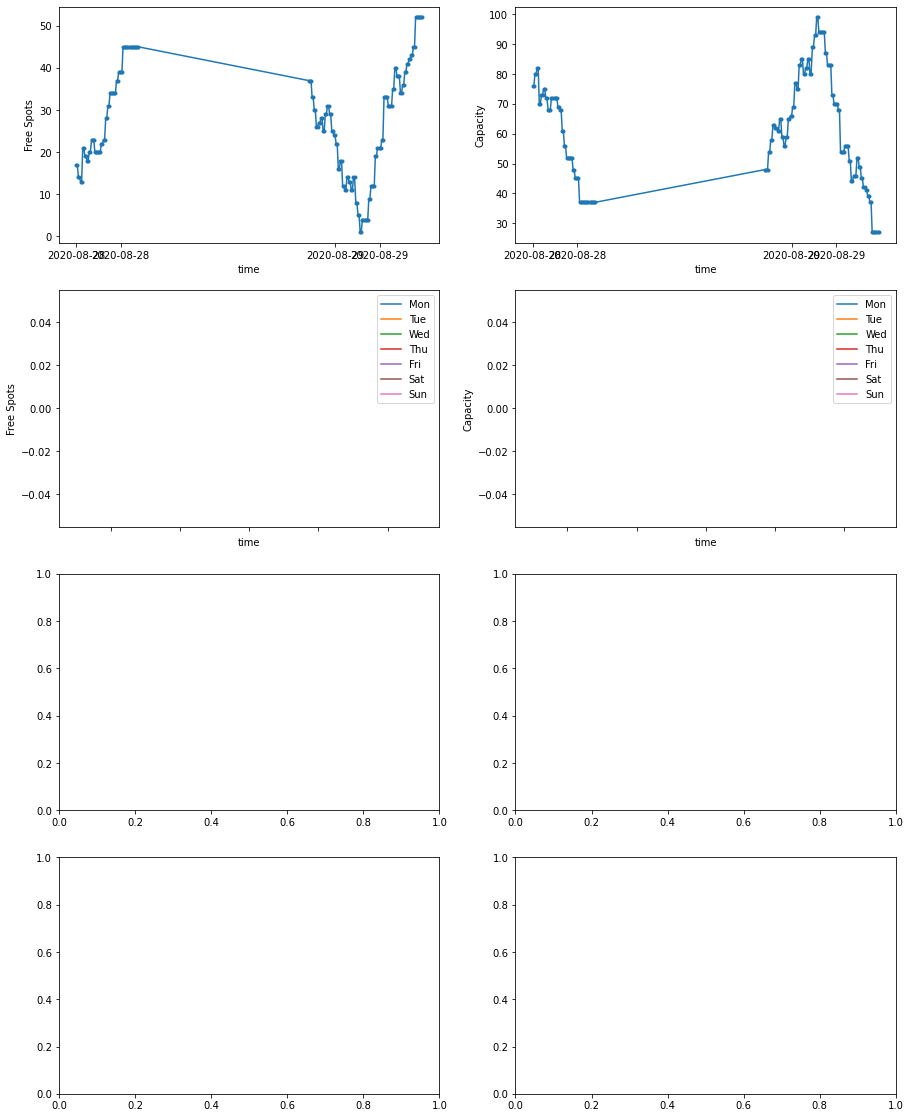

In [29]:
plot_summary_stats(data)

In [555]:
df = data.groupby(['Time','Day'])["Free Spots"].mean().unstack(fill_value=0)
cond = np.logical_and(df.index > datetime.strptime("11:00", "%H:%M").time(),df.index < datetime.strptime("11:15", "%H:%M").time())

In [625]:
for day in weekdays:
    by_day = data[data["Day"] == day]
    by_day = by_day.rename(columns={metric:day})
    by_day.groupby(["Date", "Time"]).mean()[day].plot(ax=ax[1,idx], legend=True)
    print(by_day.groupby(["Time", "Date"]).mean())

Empty DataFrame
Columns: [Free Spots, Mon]
Index: []
Empty DataFrame
Columns: [Free Spots, Tue]
Index: []
Empty DataFrame
Columns: [Free Spots, Wed]
Index: []
Empty DataFrame
Columns: [Free Spots, Thu]
Index: []
                     Free Spots  Fri
Time     Date                       
11:03:00 2020-08-28          38   46
11:08:00 2020-08-28          37   48
11:13:00 2020-08-28          37   48
11:18:00 2020-08-28          33   54
11:23:00 2020-08-28          33   54
11:28:00 2020-08-28          32   55
11:33:00 2020-08-28          32   55
11:38:00 2020-08-28          34   52
11:43:00 2020-08-28          34   52
11:48:00 2020-08-28          35   51
11:53:00 2020-08-28          35   51
11:58:00 2020-08-28          48   32
12:03:00 2020-08-28          48   32
12:08:00 2020-08-28          49   31
12:13:00 2020-08-28          49   31
12:18:00 2020-08-28          49   31
12:23:00 2020-08-28          49   31
12:28:00 2020-08-28          48   32
12:33:00 2020-08-28          48   32
12:38:00 20

In [ ]:
pd.DataFrame({"Test":[1,1],"Test1":[1,1],"Test2":[1,1]}).groupby("Test").mean

In [ ]:
pd.DataFrame().groupby().mean

In [10]:
test_times = []
M = "8"
Y = "2020"
for D in range(1,15):
    for HH in range(24):
        for MM in range(0,60,15):
            timestamp = "{0}:{1}, {2}/{3}/{4}".format(str(HH),str(MM),M,str(D),Y)
            test_times.append(datetime.strptime(timestamp, "%H:%M, %m/%d/%Y"))

In [11]:
log = pd.DataFrame(columns=["Free Spots", "Capacity", "Time", "Weekday", "DateTime"])
save2file = "log.csv"

if os.path.isfile(save2file):
    print("logfile already exists, adding new data to existing file.")
    log = pd.read_csv(save2file, sep=";")

for T in test_times:
    if is_open(T):
        if True:
            timestamp = T
            timestamp_str = datetime.strftime(timestamp, "%H:%M, %m/%d/%Y")
            weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
            timeofday = datetime.strftime(timestamp, "%H:%M")
            day = weekdays[timestamp.weekday()]

            #print("fetching data from B12 API @ " + timestamp_str, end=" --> ")
            #payload = get_current_capacity()
            absolute, relative = (0,0)
            update = pd.DataFrame({"Free Spots":[absolute], 
                                   "Capacity":[relative], 
                                   "Time":[timeofday], 
                                   "Weekday":[day], 
                                   "DateTime":[timestamp_str]
                                  })
            #print("Free Spots = {0}, Capacity = {1}%.".format(absolute, relative))
            #print("updating logfile")
            log = log.append(update, ignore_index=True, sort=False)
            #log.to_csv(save2file, index=False, sep=";")
            #print("saving to csv...")
            print(update)
            #time.sleep(2)
        else:
            print("Error while trying to reach internet. Waiting 5min then trying again...")
            #time.sleep(2)
    else:
        now = T
        closing_time, next_opening_time = is_open(now, return_state=False)
        #print("The B12 is currently closed. Waiting till it opens again @ " 
              #+ datetime.strftime(next_opening_time, "%H:%M") + "."
             #)
        #time.sleep((next_opening_time-now).seconds)
        print(day, "wait {0:.2f}, {1}, {2}".format((next_opening_time-now).seconds/(60**2), next_opening_time.time(), now.time()))

logfile already exists, adding new data to existing file.
Fri wait 10.00, 10:00:00, 00:00:00
Fri wait 9.75, 10:00:00, 00:15:00
Fri wait 9.50, 10:00:00, 00:30:00
Fri wait 9.25, 10:00:00, 00:45:00
Fri wait 9.00, 10:00:00, 01:00:00
Fri wait 8.75, 10:00:00, 01:15:00
Fri wait 8.50, 10:00:00, 01:30:00
Fri wait 8.25, 10:00:00, 01:45:00
Fri wait 8.00, 10:00:00, 02:00:00
Fri wait 7.75, 10:00:00, 02:15:00
Fri wait 7.50, 10:00:00, 02:30:00
Fri wait 7.25, 10:00:00, 02:45:00
Fri wait 7.00, 10:00:00, 03:00:00
Fri wait 6.75, 10:00:00, 03:15:00
Fri wait 6.50, 10:00:00, 03:30:00
Fri wait 6.25, 10:00:00, 03:45:00
Fri wait 6.00, 10:00:00, 04:00:00
Fri wait 5.75, 10:00:00, 04:15:00
Fri wait 5.50, 10:00:00, 04:30:00
Fri wait 5.25, 10:00:00, 04:45:00
Fri wait 5.00, 10:00:00, 05:00:00
Fri wait 4.75, 10:00:00, 05:15:00
Fri wait 4.50, 10:00:00, 05:30:00
Fri wait 4.25, 10:00:00, 05:45:00
Fri wait 4.00, 10:00:00, 06:00:00
Fri wait 3.75, 10:00:00, 06:15:00
Fri wait 3.50, 10:00:00, 06:30:00
Fri wait 3.25, 10:00:00

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  16:45     Sun  16:45, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:00     Sun  17:00, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:15     Sun  17:15, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:30     Sun  17:30, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:45     Sun  17:45, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:00     Sun  18:00, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:15     Sun  18:15, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:30     Sun  18:30, 08/02/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:00     Tue  13:00, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:15     Tue  13:15, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:30     Tue  13:30, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:45     Tue  13:45, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:00     Tue  14:00, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:15     Tue  14:15, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:30     Tue  14:30, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:45     Tue  14:45, 08/04/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:00     Wed  17:00, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:15     Wed  17:15, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:30     Wed  17:30, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  17:45     Wed  17:45, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:00     Wed  18:00, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:15     Wed  18:15, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:30     Wed  18:30, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  18:45     Wed  18:45, 08/05/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  10:00     Fri  10:00, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  10:15     Fri  10:15, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  10:30     Fri  10:30, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  10:45     Fri  10:45, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  11:00     Fri  11:00, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  11:15     Fri  11:15, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  11:30     Fri  11:30, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  11:45     Fri  11:45, 08/07/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:00     Sat  19:00, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:15     Sat  19:15, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:30     Sat  19:30, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:45     Sat  19:45, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:00     Sat  20:00, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:15     Sat  20:15, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:30     Sat  20:30, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:45     Sat  20:45, 08/08/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  12:45     Mon  12:45, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:00     Mon  13:00, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:15     Mon  13:15, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:30     Mon  13:30, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  13:45     Mon  13:45, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:00     Mon  14:00, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:15     Mon  14:15, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:30     Mon  14:30, 08/10/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:15     Tue  19:15, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:30     Tue  19:30, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  19:45     Tue  19:45, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:00     Tue  20:00, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:15     Tue  20:15, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:30     Tue  20:30, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  20:45     Tue  20:45, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  21:00     Tue  21:00, 08/11/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:00     Thu  14:00, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:15     Thu  14:15, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:30     Thu  14:30, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  14:45     Thu  14:45, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  15:00     Thu  15:00, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  15:15     Thu  15:15, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  15:30     Thu  15:30, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  15:45     Thu  15:45, 08/13/2020
   Free Spots  Capacity   Time Weekday           DateTime
0           0 

   Free Spots  Capacity   Time Weekday           DateTime
0           0         0  22:45     Fri  22:45, 08/14/2020
Fri wait 11.00, 10:00:00, 23:00:00
Fri wait 10.75, 10:00:00, 23:15:00
Fri wait 10.50, 10:00:00, 23:30:00
Fri wait 10.25, 10:00:00, 23:45:00


In [86]:
def is_open(timestamp, return_state=True):
    state = False
    opening_times = {"Mon":["09:30","23:00"], 
                     "Tue":["09:30","23:00"], 
                     "Wed":["08:30","23:00"], 
                     "Thu":["12:30","23:00"], 
                     "Fri":["09:30","23:00"], 
                     "Sat":["10:00","22:00"], 
                     "Sun":["10:00","21:30"]}
    weekdays = list(opening_times.keys())
    
    day = weekdays[timestamp.weekday()]
    opening_time, closing_time = str2datetime(opening_times[day])
    
    if timestamp.time() > opening_time.time() and timestamp.time() < closing_time.time():
        state = True
        
    if return_state:
        return state
    else:
        opening_time, closing_time = opening_times[day]
        
        if timestamp < datetime.combine((timestamp).date(), str2datetime("23:59").time()):
            next_day = weekdays[(timestamp.weekday()+1)%7]
            next_opening_time, next_closing_time = str2datetime(opening_times[next_day])
            prev_closing_time = closing_time
        else:
            prev_day = weekdays[(timestamp.weekday()-1)%7]
            prev_opening_time, prev_closing_time = str2datetime(opening_times[prev_day])
            next_opening_time = opening_time
        
        return prev_closing_time, next_opening_time
    
for time in test_times:
    print(weekdays[timestamp.weekday()], time.time())
    print(is_open(time, False))

Fri 00:00:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 00:15:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 00:30:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 00:45:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 01:00:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 01:15:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 01:30:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 01:45:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 02:00:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 02:15:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 02:30:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 02:45:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 03:00:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 03:15:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 03:30:00
yes
('22:00', datetime.datetime(1900, 1, 1, 10, 0))
Fri 03:45:00
yes
('22:00'

Fri 22:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 22:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 22:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 23:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 23:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 23:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 23:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 00:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 00:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 00:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 00:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 01:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 01:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 01:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 01:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 02:00:00
yes
(

yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 01:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 02:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 02:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 02:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 02:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 03:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 03:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 03:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 03:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 04:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 04:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 04:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 04:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 05:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 9, 30))
Fri 05:15:00
yes
('23:00', datetime.da

Fri 16:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 16:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 16:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 17:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 17:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 17:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 17:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 18:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 18:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 18:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 18:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 19:00:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 19:15:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 19:30:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 19:45:00
yes
('23:00', datetime.datetime(1900, 1, 1, 12, 30))
Fri 20:00: